# External DB memory

In [1]:
from langchain.chat_models import init_chat_model
model = init_chat_model(
    "anthropic.claude-3-haiku-20240307-v1:0",
    model_provider="bedrock_converse",
)

In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [3]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [4]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [5]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END
from langgraph.graph import MessagesState
from typing import Literal

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}


def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

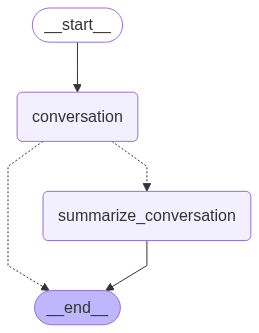

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I'm Claude, an AI assistant created by Anthropic. How can I help you today?
================================== Ai Message ==================================

Your name is Lance, as you introduced yourself to me earlier.
================================== Ai Message ==================================

That's great! The San Francisco 49ers are a popular NFL team. As an AI, I don't have personal sports team preferences, but I'm always happy to discuss football or other topics that interest you. What do you enjoy most about being a 49ers fan?


In [9]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state.values.get("summary","")

''

In [10]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='e0a7c847-6797-4edc-aaaa-bda67745eec7'), AIMessage(content="Hello Lance! It's nice to meet you. I'm Claude, an AI assistant created by Anthropic. How can I help you today?", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '6dc73522-c9c1-42e2-b84f-be59ff948c75', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 14 Jul 2025 23:18:47 GMT', 'content-type': 'application/json', 'content-length': '292', 'connection': 'keep-alive', 'x-amzn-requestid': '6dc73522-c9c1-42e2-b84f-be59ff948c75'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [562]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--1063295e-7a5a-483c-8c09-f976403710f6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 33, 'total_tokens': 45, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content="what's my 

### Persisting State
Using database like Sqlite means state is persisted!
For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.

In [12]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='dc9218e2-53d1-43c4-9c01-17715da179c4'), AIMessage(content="Hi Lance! It's nice to meet you. I'm Claude, an AI assistant created by Anthropic. How can I assist you today?", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '18d0d377-0c8e-45ff-88ef-58d3fd22ed48', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 14 Jul 2025 22:25:16 GMT', 'content-type': 'application/json', 'content-length': '291', 'connection': 'keep-alive', 'x-amzn-requestid': '18d0d377-0c8e-45ff-88ef-58d3fd22ed48'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [574]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--0129da00-c62d-424f-9a8e-da0b35bfbb4a-0', usage_metadata={'input_tokens': 12, 'output_tokens': 33, 'total_tokens': 45, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content="what's my n